In [208]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import isfile
from tqdm.notebook import tqdm
import pickle

In [118]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# paint ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle

In [2]:
img1 = cv2.imread('plaid_fabric/002e53a4498f447e83d591931f4750c5.jpg')
img2 = cv2.imread('floral_fabric/0039a49d5e2a41eaa4d819263920ff66.jpg')
img3 = cv2.imread('zigzag_fabric/001685e41acf4233a0db19e9ea0ba02a.jpg')

<Figure size 640x480 with 0 Axes>

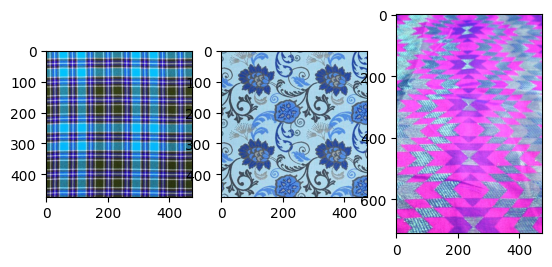

In [13]:
fig,ax = plt.subplots(1,3)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)
plt.show()

# BOW

In [252]:
images = []
root='clean/'
folders = os.listdir(root)
folders = [f for f in folders if not isfile(f)]
labels = folders
num_classes = 5
num_img_per_class = 400
for folder in tqdm(folders[:num_classes]):
    files = os.listdir(root+folder)
    for file in tqdm(files[:num_img_per_class], leave=0):
        if 'jpg' in file.split('.')[1]:
            images.append(cv2.imread(folder+'/'+file))

nlabels = generate_num_labels(num_classes, num_img_per_class)
len(images)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

1995

In [254]:
print(labels[:num_classes])

['camouflage_fabric', 'zigzag_fabric', 'polka_dot_fabric', 'floral_fabric', 'striped_fabric']


In [101]:
def generate_num_labels(num_classes=None, num_photos_per_class=None):
    if (not num_photos_per_class) | (not num_classes):
        print("must specify num_classes and num_photos_per_class, assumes balanced classes")
        return None
    total = num_classes*num_photos_per_class
    numeric_labels = np.zeros(total, np.int32)
    for i in range(total):
        numeric_labels[i] = i // num_photos_per_class
    return numeric_labels

In [102]:
def create_bag_of_words(images, k_size=10):
    print("Creating the unclustered geometric vocabulary")
    descriptors, keypoints = [], []
    vocabulary = cv2.BOWKMeansTrainer(clusterCount=k_size)
    detector = cv2.SIFT_create()

    for img in images:
        kp, descriptor = detector.detectAndCompute(img, None)
        descriptors.append(descriptor)
        keypoints.append(kp)
        vocabulary.add(descriptor.astype(np.float32))

    BOW = vocabulary.cluster()
    BOW = BOW.astype(np.float32)
    print("Done creating the clusters with K-means")

    return BOW, keypoints, descriptors

In [216]:
def compute_BOW_response(BOW, images, nlabels, keypoints, descriptors, k_size=10):
    print("Computing the descriptors for the images")
    matcher = cv2.BFMatcher(normType=cv2.NORM_L2)
    detector = cv2.SIFT_create()
    BOW_extractor = cv2.BOWImgDescriptorExtractor(dextractor=detector, dmatcher=matcher)

    # Set the vocabulary for the BOW extractor,
    # in order to compute the histograms for the images
    BOW_extractor.setVocabulary(BOW)
    BOW_descriptors = np.zeros([len(nlabels), k_size], dtype=np.float32)
    #print(BOW_descriptors.shape)

    # Compute the histograms
    i = 0
    for img in images:
        kps = detector.detect(img)
        hist = BOW_extractor.compute(img, kps)
        BOW_descriptors[i] = hist[0].flatten()
        i+=1
    print("Done computing the descriptors for the images")

    return np.array(BOW_descriptors)

In [179]:
def create_test_subset(size, num_photos_class, objs_class):
    subset = []
    for i in range(0, size, num_photos_class):
        up_ = i+num_photos_class
        up_ = up_ if up_ < size else size
        subset += np.random.randint(low=i, high=up_, size=objs_class).tolist()
    return np.array(subset)


def generate_train_test_masks(size,
                              num_photos_class = 80,
                              objs_class = 4):
    # Test index
    test_subset = create_test_subset(size, num_photos_class, objs_class)

    aux = np.arange(size)
    # Training index
    training_subset = np.in1d(aux, test_subset) * 1
    training_subset = np.where(training_subset == 0)[0]

    # Return both of them
    return training_subset, test_subset

In [181]:
"""
Cross validation functions to test SVM and RF
"""
def cv_rf(data,nlabels, kfold):
    rfb = RandomForestClassifier(n_estimators=60, criterion="entropy", oob_score=True, n_jobs=-1)
    rfn = RandomForestClassifier(n_estimators=60, criterion="entropy", oob_score=False, n_jobs=-1, bootstrap=False)
    scoresrfb = cross_val_score(rfb, data, nlabels, cv=kfold)
    scoresrfn = cross_val_score(rfn, data, nlabels, cv=kfold)
    print("Random Forest cross validation accuracy:")
    print("\tWith boosting")
    print("\t\tBest: %0.2f" % scoresrfb.max())
    print("\t\tAccuracy: %0.2f (+/- %0.2f)" % (scoresrfb.mean(), scoresrfb.std() * 2))
    print("\tWithout boosting")
    print("\t\tBest: %0.2f" % scoresrfn.max())
    print("\t\tAccuracy: %0.2f (+/- %0.2f)" % (scoresrfn.mean(), scoresrfn.std() * 2))
    return rfb, rfn


def cv_svm(data, nlabels, kfold):
    svm_onevsall = SVC(cache_size=200, C=180, gamma=0.5, tol=1e-7, shrinking=False, decision_function_shape='ovr')
    svm_onevsone = SVC(cache_size=200, C=180, gamma=0.5, tol=1e-7, shrinking=False, decision_function_shape='ovo')
    print("SVM cross validation accuracy:")
    scores_onevsall = cross_val_score(svm_onevsall, data, nlabels, cv=kfold)
    print("\tSVM one vs all:")
    print("\t\tBest: %0.2f"%scores_onevsall.max())
    print("\t\tAccuracy: %0.2f (+/- %0.2f)" % (scores_onevsall.mean(), scores_onevsall.std() * 2))
    scores_onevsone = cross_val_score(svm_onevsone, data, nlabels, cv=kfold)
    print("\tSVM one vs one:")
    print("\t\tBest: %0.2f"%scores_onevsone.max())
    print("\t\tAccuracy: %0.2f (+/- %0.2f)" % (scores_onevsone.mean(), scores_onevsone.std() * 2))
    return svm_onevsall, svm_onevsone

In [180]:
def calculate_roc_curve(data, labels, model, training, test, svm, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if svm:
        y_score = model.fit(X=data[training], y=labels[training]).decision_function(data[test])
    else:
        rt_lm = LogisticRegression()
        pipeline = make_pipeline(model, rt_lm)
        pipeline.fit(data[training],labels[training])
        y_score = pipeline.predict_proba(data[test])

    y = label_binarize(y=labels, classes=list(range(y_score[0].size)))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[test][:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y[test].ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

def multiclass_roc_curve(data, labels, model, filename, training, test, svm, label_list, n_classes=17):
    fpr, tpr, roc_auc = calculate_roc_curve(data, labels, model, training, test, svm, n_classes)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw=2
    # Plot all ROC curves
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    ax.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'mediumseagreen', 'orchid', 'lightpink',
                    'darkslateblue', 'purple', 'darkblue', 'skyblue', 'red', 'firebrick',
                    'coral', 'maroon', 'grey', 'skyblue', 'seagreen'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='Class {} (area = {})'.format(label_list[i], roc_auc[i]))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC por clases para KAZE con k=500')
    # plt.legend(loc="lower right")
    plt.savefig(filename + ".png")

In [219]:
def train_model(images, nlabels, labels, bow_filename="bow", roc_filename="roc", k_size=10):
    # Create geometric vocabulary of the images and then, we do K-Means
    # clustering to create the Bag Of Words and get the
    # labels and histograms of every class
    BOW = None
    if not isfile(bow_filename+".npy"):
        BOW, keypoints, descriptors = create_bag_of_words(images, k_size)
        BOW_descriptors = compute_BOW_response(BOW, images, nlabels, keypoints, descriptors, k_size)
        np.save(file=bow_filename, arr=BOW_descriptors)
        pickle.dump(BOW, file=open('bow_vocab.pkl', 'wb'))
    else:
        BOW = pickle.load(BOW, file=open('bow_vocab.pkl', 'rb'))
        BOW_descriptors = np.load(bow_filename+".npy")

    data = BOW_descriptors

    # Declare the index for the training and test subset
    training, test = generate_train_test_masks(size=len(images), num_photos_class=int(len(images)/len(labels)))
    
    # errors_svm = ml.svm(data=data, nlabels=nlabels, training=training, test=test)
    # errors_rf = ml.rf(data=data, nlabels=nlabels, training=training, test=test)
    rf = cv_rf(data, nlabels, 30)
    svm = cv_svm(data, nlabels, 30)

    # ml.paint_roc_curve(data=data, labels=nlabels, training=training, test=test,
    #                    model_list=[svm[0], svm[1], rf[0], rf[1]],
    #                    filename=roc_filename, svm_list=[True, True, False, False],
    #                    label_list=["SVM One VS All", "SVM One VS One", "Boosting", "RF"])

    multiclass_roc_curve(data=data, labels=nlabels, training=training, test=test,
                            model = svm[0], filename=roc_filename, label_list=labels, svm=True, 
                            n_classes=len(labels))
    
    return rf, svm, BOW

In [255]:
%%time
k=num_classes
rf, svm, BOW = train_model(images=images, nlabels=nlabels, labels=labels[:num_classes], k_size=k)

Creating the unclustered geometric vocabulary


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-oe0iat4a/opencv/modules/features2d/src/sift.dispatch.cpp:477: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'


In [223]:
BOW.shape

(5, 128)

In [246]:
img = cv2.imread('zigzag_fabric/2474b1a4065a4a54925adcf5cc8e414e.jpg')
#plt.imshow(img)
#plt.show()

In [247]:
matcher = cv2.BFMatcher(normType=cv2.NORM_L2)
detector = cv2.SIFT_create()
BOW_extractor = cv2.BOWImgDescriptorExtractor(dextractor=detector, dmatcher=matcher)
BOW_extractor.setVocabulary(BOW)

kps = detector.detect(img)
hist = BOW_extractor.compute(img, kps)
data = hist[0].flatten()

In [248]:
svm[0].predict(X=data.reshape(1, -1))

array([4], dtype=int32)

In [231]:
labels

['camouflage_fabric',
 'zigzag_fabric',
 'lace_fabric',
 'polka_dot_fabric',
 'floral_fabric',
 'striped_fabric',
 'plaid_fabric',
 '.ipynb_checkpoints',
 'paisley_fabric',
 'geometric_fabric',
 'plain_fabric']